In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

torch-0.4.1-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models, utils
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


# Data upload

**Data Upload**

After installing all the necessary libraries and packages, we upload our data. Data represented as two numpy files. X.npy  with images and Y.npy with corresponding labels. 

In [4]:
import zipfile
with zipfile.ZipFile('Sign-language-digits-dataset.zip', 'r') as f:
    f.extractall()

In [5]:
X_0 = np.load("X.npy")
Y = np.load("Y.npy")
print(X_0.shape, Y.shape)

(2062, 64, 64) (2062, 10)


Next, we want to see dimensions and representation of our data


In [6]:
print("Sample X: ")
print( X_0[1])
print("Sample X shape: ", X_0[1].shape)
print("Sample Y: ")
print( Y[1])
print("Sample Y shape: ", Y[1].shape)

Sample X: 
[[0.59607846 0.60784316 0.61960787 ... 0.4627451  0.4509804  0.44313726]
 [0.60784316 0.61960787 0.6313726  ... 0.4745098  0.4627451  0.4509804 ]
 [0.6156863  0.627451   0.6431373  ... 0.4862745  0.4745098  0.4627451 ]
 ...
 [0.50980395 0.5176471  0.5254902  ... 0.40392157 0.39607844 0.3882353 ]
 [0.5019608  0.50980395 0.5176471  ... 0.4        0.39215687 0.38431373]
 [0.49411765 0.5058824  0.50980395 ... 0.3882353  0.38039216 0.37254903]]
Sample X shape:  (64, 64)
Sample Y: 
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sample Y shape:  (10,)



As we can see, our image represented as 64 by 64 array and labels represented as on-hot vectors. We need to convert labels to numerical labels

0


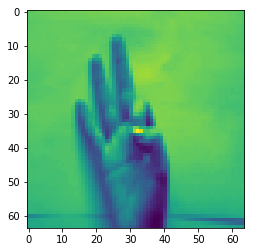

In [7]:
i = 30
Y_l= np.argmax(Y, axis=1)

Y_l.shape
plt.imshow(X_0[i])
print(Y_l[i])

We need to add an extra channel to our images to be able to use convolutional neural networks and convert our numpy arrays to Pytorch tensors.


In [8]:
X = X_0.reshape((-1, 1, 64, 64))
images = X
labels = Y_l
np.unique(Y_l)
print(images.shape, labels.shape)
print("Unique Classes: ", np.unique(Y_l))

(2062, 1, 64, 64) (2062,)
Unique Classes:  [0 1 2 3 4 5 6 7 8 9]


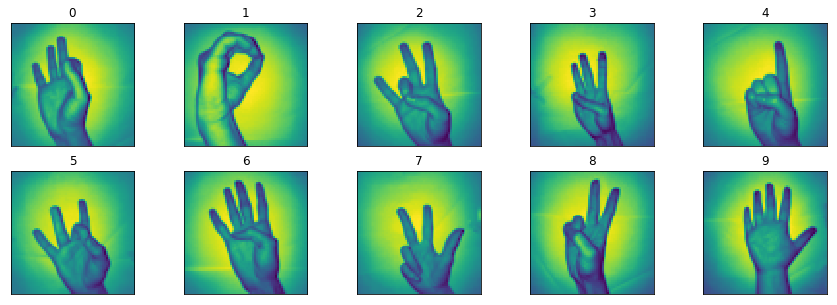

In [9]:
#Plot 10 unique classes with corresponding labels
fig = plt.figure(figsize=(15, 5))
for idx in range(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images[labels.tolist().index(idx)][0])
    ax.set_title( idx)
    #ax.set_title( classes[idx])

From the previous figure we can see what our labels are not correct. To address this issue, the simplest way to assign correct value to the corresponding label, using the lookup dictionary. 

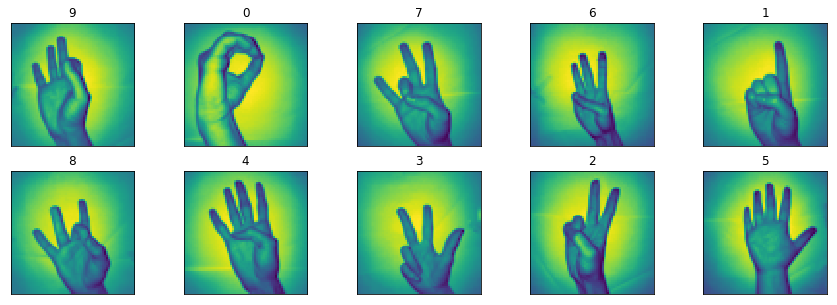

In [10]:
#The lookup dictionary.
classes = {0:9,1:0,2:7,3:6,4:1,5:8,6:4,7:3,8:2,9:5}

#Plot 10 unique classes with corresponding labels
fig = plt.figure(figsize=(15, 5))
for idx in range(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(X[Y_l.tolist().index(idx)][0])  
    ax.set_title( classes[idx])

# Check Label Distribution

In [11]:
import pandas as pd

In [12]:
df = pd.DataFrame({'label':list(Y_l)})

In [13]:
df.shape

(2062, 1)

In [14]:
df.nunique()

label    10
dtype: int64

In [15]:
df.groupby('label')['label'].count()

label
0    204
1    205
2    206
3    207
4    206
5    208
6    207
7    206
8    206
9    207
Name: label, dtype: int64

# Prepare Dataset

Now all our data is in a correct format, we can create a custom-made Dataset, where each image has a corresponding label, allowing us to shuffle, split and manipulate our dataset. 


In [16]:
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)
images_val, images_test, labels_val, labels_test =  train_test_split(images_test, labels_test, test_size=0.5, stratify=labels_test, random_state=42)

In [17]:
pd.DataFrame({'label':list(labels_train)}).groupby('label')['label'].count()

label
0    163
1    164
2    165
3    166
4    165
5    166
6    165
7    165
8    165
9    165
Name: label, dtype: int64

In [18]:
pd.DataFrame({'label':list(labels_val)}).groupby('label')['label'].count()

label
0    20
1    21
2    20
3    21
4    20
5    21
6    21
7    21
8    20
9    21
Name: label, dtype: int64

In [19]:
pd.DataFrame({'label':list(labels_test)}).groupby('label')['label'].count()

label
0    21
1    20
2    21
3    20
4    21
5    21
6    21
7    20
8    21
9    21
Name: label, dtype: int64

In [20]:
images_train = torch.from_numpy(images_train)
images_val = torch.from_numpy(images_val)
images_test = torch.from_numpy(images_test)

labels_train = torch.from_numpy(labels_train)
labels_val = torch.from_numpy(labels_val)
labels_test = torch.from_numpy(labels_test)

In [21]:
class Dataset(Dataset):
  #creating a custom dataset
  def __init__(self, images, labels):
        #init images and data
        self.images = images
        self.labels = labels

  def __len__(self):
        #getting lenght of dataset
        return len(self.images)

  def __getitem__(self, idx):        
        # Select sample    
        image = self.images[idx]
        label = self.labels[idx]

        return image, label
train_sign_language_dataset = Dataset(images_train, labels_train)
val_sign_language_dataset = Dataset(images_val, labels_val)
test_sign_language_dataset = Dataset(images_test, labels_test)

print("Random sample from our dataset: ")
print(train_sign_language_dataset[1000])

Random sample from our dataset: 
(tensor([[[0.7804, 0.7961, 0.8118,  ..., 0.7961, 0.7882, 0.7804],
         [0.8000, 0.8118, 0.8118,  ..., 0.8000, 0.7961, 0.7569],
         [0.8039, 0.8000, 0.8118,  ..., 0.8157, 0.8039, 0.7608],
         ...,
         [0.6706, 0.6667, 0.6667,  ..., 0.6745, 0.6745, 0.6667],
         [0.6667, 0.6667, 0.6667,  ..., 0.6706, 0.6706, 0.6667],
         [0.6627, 0.6627, 0.6627,  ..., 0.6706, 0.6706, 0.6627]]]), tensor(6))


In [22]:
len(train_sign_language_dataset), len(val_sign_language_dataset), len(test_sign_language_dataset)

(1649, 206, 207)

For training our classifier we split our Dataset into training, validation and test sets, in proportion 8:1:1.

In [23]:
# initiate parameters for splitting our data
num_workers = 1
batch_size =16


# define samplers for obtaining training, validation and test batches

# load our batches
train_loader = torch.utils.data.DataLoader(train_sign_language_dataset,
                                           batch_size=batch_size,
                                           num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(val_sign_language_dataset,
                                           batch_size=batch_size,
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_sign_language_dataset,
                                           batch_size=batch_size,                                      
                                           num_workers=num_workers)

print("Length of training set: ",len(train_loader))
print("Length of validation set: ",len(valid_loader))
print("Length of test set: ",len(test_loader))

Length of training set:  104
Length of validation set:  13
Length of test set:  13


This is our one training batch visualised. 

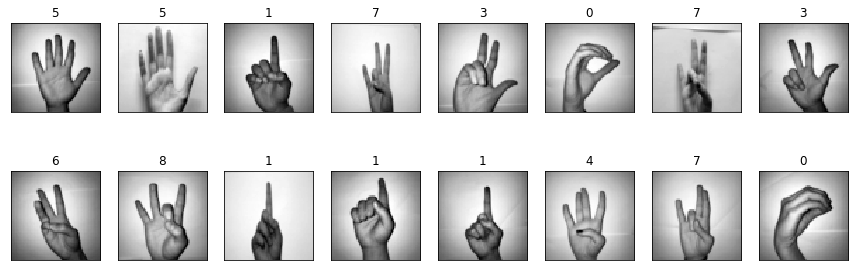

In [24]:
# obtain one batch of training images and plot these images
dataiter = iter(train_loader)
images, labels = dataiter.next()

fig = plt.figure(figsize=(15,5))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx][0], cmap='gray')
    ax.set_title(classes[labels.tolist()[idx]])

#Model



---


**Classifier Model**


Let us define our model, it has 3 convolutional layers with pooling and 2 fully connected layers, with dropouts and Relu activation functions.


**Train and validate our model**

1. Train

*   Initialize our loss function and optimizer
*   Run training batch 
*   Calculate the loss
*   Backpropagate
*   Update weights


2. Validate


*   Feedforward validation batch
*   Compute error
*   If validation loss decreased save our model

3.Repeat

For the number of epochs









In [25]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
      
        self.conv1_1 = nn.Conv2d(1, 8, 3, padding=1)      
        self.conv1_2 = nn.Conv2d(8, 8, 3, padding=1)      
        self.conv1_3 = nn.Conv2d(8, 8, 3, padding=1)
        
        self.pool1 = nn.MaxPool2d(2, 2) 
        
        self.conv2_1 = nn.Conv2d(8, 16, 3, padding=1)      
        self.conv2_2 = nn.Conv2d(16, 16, 3, padding=1)      
        self.conv2_3 = nn.Conv2d(16, 16, 3, padding=1)

        self.pool2 = nn.MaxPool2d(2, 2) 
        
        self.conv3_1 = nn.Conv2d(16, 32, 3, padding=1)      
        self.conv3_2 = nn.Conv2d(32, 32, 3, padding=1)      
        self.conv3_3 = nn.Conv2d(32, 32, 3, padding=1)
        
        self.pool3 = nn.MaxPool2d(2, 2) 
        
        self.conv4_1 = nn.Conv2d(32, 64, 3, padding=1)      
        self.conv4_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv4_3 = nn.Conv2d(64, 64, 3, padding=1)
        
        self.fc = nn.Linear(64, 10)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        # 64x64x1 => 32x32x8
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = F.relu(self.conv1_3(x))
        x = self.pool1(x)
        
        # 32x32x8 => 16x16x16
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = F.relu(self.conv2_3(x))
        x = self.pool2(x)
        
        # 16x16x16 => 8x8x32
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.pool3(x)
        
        # 8x8x32 => 8x8x10
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = F.log_softmax(self.fc(x.view(-1, 64, 8*8).sum(dim=-1)), dim=-1)

        return x

In [32]:
model = Net()
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
print(model)

Net(
  (conv1_1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_1): Conv2d(32, 64, kerne

In [33]:
model(torch.randn(5,1,64,64))

tensor([[-20.0331, -92.0094, -57.9534, -91.6185, -34.1636,   0.0000, -52.1988,
         -39.9701, -32.5570, -22.9783],
        [-21.4173, -90.8942, -58.0364, -91.6090, -35.1975,   0.0000, -52.6802,
         -40.7142, -35.3284, -25.2248],
        [-20.3879, -91.9341, -57.5043, -90.7811, -34.7221,   0.0000, -51.4897,
         -39.5793, -32.0340, -24.5663],
        [-20.0707, -91.5329, -57.1322, -91.4982, -34.0412,   0.0000, -51.9252,
         -40.9399, -33.2483, -23.7586],
        [-19.5207, -90.2049, -56.6426, -89.0048, -34.0155,   0.0000, -51.9286,
         -40.4962, -31.4110, -24.3982]], grad_fn=<LogSoftmaxBackward>)

In [34]:
#loss function
criterion = nn.NLLLoss()

In [35]:
model = Net()
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

# number of epochs to train the model
n_epochs = 20
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):
    # Update Learning Rate
    lr = 1e-3 * (1 - (0.05 * (epoch - 1)))
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0    
    
    # train the model    
    
    model.train()
    for data, target in train_loader:        
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()       
        optimizer.zero_grad()
        output = model(data)       
        loss = criterion(output, target)
        loss.backward()       
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    
    # validate the model 
  
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
       
        output = model(data)       
        loss = criterion(output, target)       
        valid_loss += loss.item()*data.size(0)    
   
    train_loss = train_loss/len(train_sign_language_dataset)
    valid_loss = valid_loss/len(val_sign_language_dataset)        
   
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        torch.save(model.state_dict(), 'model_sl.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.812404 	Validation Loss: 2.498377
Validation loss decreased (inf --> 2.498377).  Saving model ...
Epoch: 2 	Training Loss: 2.393933 	Validation Loss: 2.461869
Validation loss decreased (2.498377 --> 2.461869).  Saving model ...
Epoch: 3 	Training Loss: 2.359593 	Validation Loss: 2.393743
Validation loss decreased (2.461869 --> 2.393743).  Saving model ...
Epoch: 4 	Training Loss: 2.351651 	Validation Loss: 2.343953
Validation loss decreased (2.393743 --> 2.343953).  Saving model ...
Epoch: 5 	Training Loss: 2.269876 	Validation Loss: 2.071616
Validation loss decreased (2.343953 --> 2.071616).  Saving model ...
Epoch: 6 	Training Loss: 1.705093 	Validation Loss: 1.427397
Validation loss decreased (2.071616 --> 1.427397).  Saving model ...
Epoch: 7 	Training Loss: 1.001994 	Validation Loss: 0.653875
Validation loss decreased (1.427397 --> 0.653875).  Saving model ...
Epoch: 8 	Training Loss: 0.468414 	Validation Loss: 0.284576
Validation loss decreased (0.65387

**Test the model**

Test and visualize our model.
Credits to Udasity for multi classes validation  and plotting.  [GitHub](https://github.com/udacity/deep-learning-v2-pytorch)

In [38]:
# track test loss
train_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in train_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    train_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
   
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.tolist()[i]
        class_correct[label] += correct_tensor.tolist()[i]
        class_total[label] += 1

# # average test loss
train_loss = train_loss/len(train_loader.dataset)
print('Train Loss: {:.6f}\n'.format(train_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Train Accuracy of %5s: %.4f%% (%d/%d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Train Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTrain Accuracy (Overall): %.4f%% (%d/%d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
  

Train Loss: 0.002396

Train Accuracy of     9: 100.0000% (163/163)
Train Accuracy of     0: 100.0000% (164/164)
Train Accuracy of     7: 100.0000% (165/165)
Train Accuracy of     6: 100.0000% (166/166)
Train Accuracy of     1: 100.0000% (165/165)
Train Accuracy of     8: 100.0000% (166/166)
Train Accuracy of     4: 100.0000% (165/165)
Train Accuracy of     3: 100.0000% (165/165)
Train Accuracy of     2: 98.7879% (163/165)
Train Accuracy of     5: 100.0000% (165/165)
\Train Accuracy (Overall): 99.8787% (1647/1649)


In [39]:
# track test loss
val_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in train_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    val_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
   
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.tolist()[i]
        class_correct[label] += correct_tensor.tolist()[i]
        class_total[label] += 1

# # average test loss
val_loss = val_loss/len(valid_loader.dataset)
print('Valid Loss: {:.6f}\n'.format(val_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Valid Accuracy of %5s: %.4f%% (%d/%d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Valid Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nValid Accuracy (Overall): %.4f%% (%d/%d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
  

Valid Loss: 0.019183

Valid Accuracy of     9: 100.0000% (163/163)
Valid Accuracy of     0: 100.0000% (164/164)
Valid Accuracy of     7: 100.0000% (165/165)
Valid Accuracy of     6: 100.0000% (166/166)
Valid Accuracy of     1: 100.0000% (165/165)
Valid Accuracy of     8: 100.0000% (166/166)
Valid Accuracy of     4: 100.0000% (165/165)
Valid Accuracy of     3: 100.0000% (165/165)
Valid Accuracy of     2: 98.7879% (163/165)
Valid Accuracy of     5: 100.0000% (165/165)
\Valid Accuracy (Overall): 99.8787% (1647/1649)


In [40]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
   
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.tolist()[i]
        class_correct[label] += correct_tensor.tolist()[i]
        class_total[label] += 1

# # average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %.4f%% (%d/%d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %.4f%% (%d/%d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
  

Test Loss: 0.045778

Test Accuracy of     9: 100.0000% (21/21)
Test Accuracy of     0: 90.0000% (18/20)
Test Accuracy of     7: 100.0000% (21/21)
Test Accuracy of     6: 95.0000% (19/20)
Test Accuracy of     1: 100.0000% (21/21)
Test Accuracy of     8: 95.2381% (20/21)
Test Accuracy of     4: 100.0000% (21/21)
Test Accuracy of     3: 100.0000% (20/20)
Test Accuracy of     2: 100.0000% (21/21)
Test Accuracy of     5: 100.0000% (21/21)

Test Accuracy (Overall): 98.0676% (203/207)


In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

output = model(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(15,5))
for idx in np.arange(12):
    ax = fig.add_subplot(2, 12/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx][0])
    ax.set_title("Pred {} (True {})".format(classes[preds[idx].tolist()], classes[labels[idx].tolist()]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))